In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [38]:
import os
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF #
from PIL import Image


target_size = (256, 256)
resize_transform = T.Resize(target_size, interpolation=Image.NEAREST)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

class VOCSegmentationDataset(Dataset):
    def __init__(self, filenames, image_dir, mask_dir, resize_transform, normalize_transform, object_class_ids):
        self.filenames = filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.resize_transform = resize_transform
        self.normalize_transform = normalize_transform
        self.object_class_ids = object_class_ids

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_name = image_name.replace('.jpg', '.png')
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        image = self.resize_transform(image)
        mask = self.resize_transform(mask)

        if random.random() > 0.5:
            image = TF.hflip(image)
            mask = TF.hflip(mask)

        rotation_degrees = random.randint(-10, 10)
        image = TF.rotate(image, rotation_degrees)
        mask = TF.rotate(mask, rotation_degrees)

        mask_np = np.array(mask)
        binary_mask = np.zeros_like(mask_np, dtype=np.float32)

        for obj_id in self.object_class_ids:
            binary_mask[mask_np == obj_id] = 1

        image = T.ToTensor()(image)
        image = self.normalize_transform(image)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0)

        return image, binary_mask

In [54]:
random.seed(42)
random.shuffle(images_with_any_object)
train_split = int(len(images_with_any_object) * 0.8)
val_split = int(len(images_with_any_object) * 0.1)

train_filenames = images_with_any_object[:train_split]
val_filenames = images_with_any_object[train_split:train_split + val_split]
test_filenames = images_with_any_object[train_split + val_split:]

train_dataset = VOCSegmentationDataset(train_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)
val_dataset = VOCSegmentationDataset(val_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)
test_dataset = VOCSegmentationDataset(test_filenames, image_dir, mask_dir, resize_transform, normalize, object_class_ids)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [46]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as models
from torchvision.models.segmentation import DeepLabV3_ResNet50_Weights


model = models.deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("✅ Pre-trained DeepLabV3 model loaded.")

✅ Pre-trained DeepLabV3 model loaded.


In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

def train_and_validate(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-5) # Changed learning rate

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        start_time = time.time()
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)["out"]
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_loss = train_loss / len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)["out"]
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        end_time = time.time()
        duration = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {duration:.2f}s")
    return model

trained_model = train_and_validate(model, train_loader, val_loader, num_epochs=5, device=device)

torch.save(trained_model.state_dict(), "my_deeplabv3_model.pth")
print("✅ Model saved as my_deeplabv3_model.pth")

Epoch [1/5] - Train Loss: 0.7062, Val Loss: 0.6483, Time: 35.01s
Epoch [2/5] - Train Loss: 0.6857, Val Loss: 0.6502, Time: 33.85s
Epoch [3/5] - Train Loss: 0.6726, Val Loss: 0.6562, Time: 32.99s
Epoch [4/5] - Train Loss: 0.6548, Val Loss: 0.6517, Time: 33.39s
Epoch [5/5] - Train Loss: 0.6405, Val Loss: 0.6497, Time: 33.09s
✅ Model saved as my_deeplabv3_model.pth


In [49]:
import torch
import numpy as np

def iou_score(outputs, masks):
    predicted_masks = torch.sigmoid(outputs)
    predicted_masks = (predicted_masks > 0.5).float()
    outputs_flat = predicted_masks.view(-1)
    masks_flat = masks.view(-1)
    intersection = (outputs_flat * masks_flat).sum()
    union = outputs_flat.sum() + masks_flat.sum() - intersection
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.item()

def dice_score(outputs, masks):
    predicted_masks = torch.sigmoid(outputs)
    predicted_masks = (predicted_masks > 0.5).float()
    outputs_flat = predicted_masks.view(-1)
    masks_flat = masks.view(-1)
    intersection = (outputs_flat * masks_flat).sum()
    dice = (2. * intersection + 1e-6) / (outputs_flat.sum() + masks_flat.sum() + 1e-6)
    return dice.item()

def pixel_accuracy(outputs, masks):
    predicted_masks = torch.sigmoid(outputs)
    predicted_masks = (predicted_masks > 0.5).float()
    correct_pixels = (predicted_masks == masks).float().sum()
    total_pixels = torch.numel(masks)
    accuracy = correct_pixels / total_pixels
    return accuracy.item()

metrics = {"IoU": [], "Dice": [], "PixelAcc": []}
trained_model.eval()

with torch.no_grad():
    for imgs, masks in val_loader:
        imgs = imgs.to(device)
        masks = masks.to(device)
        outputs = trained_model(imgs)["out"]
        metrics["IoU"].append(iou_score(outputs, masks))
        metrics["Dice"].append(dice_score(outputs, masks))
        metrics["PixelAcc"].append(pixel_accuracy(outputs, masks))

print(f"Mean IoU: {np.mean(metrics['IoU']):.4f}")
print(f"Mean Dice: {np.mean(metrics['Dice']):.4f}")
print(f"Pixel Accuracy: {np.mean(metrics['PixelAcc']):.4f}")

Mean IoU: 0.6472
Mean Dice: 0.7858
Pixel Accuracy: 0.7558


In [50]:
import torch
torch.save(trained_model.state_dict(), "my_final_model.pth")
print("✅ Final model saved as my_final_model.pth")

✅ Final model saved as my_final_model.pth


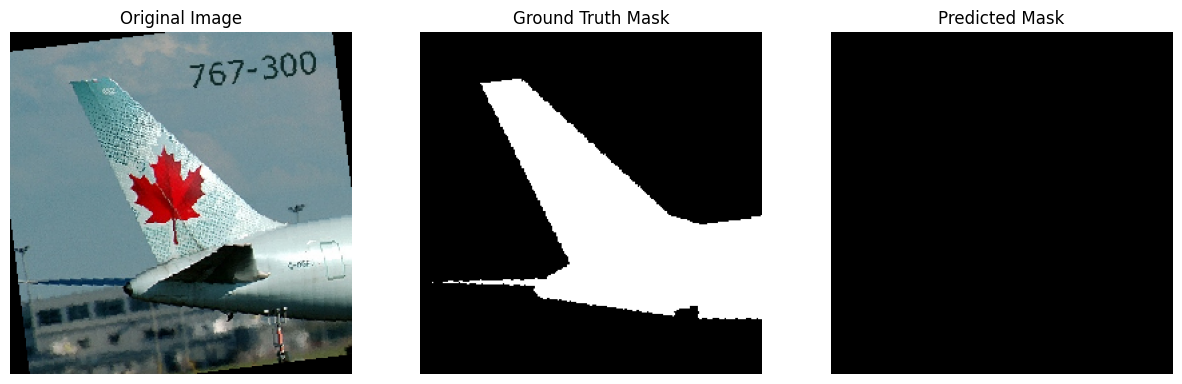

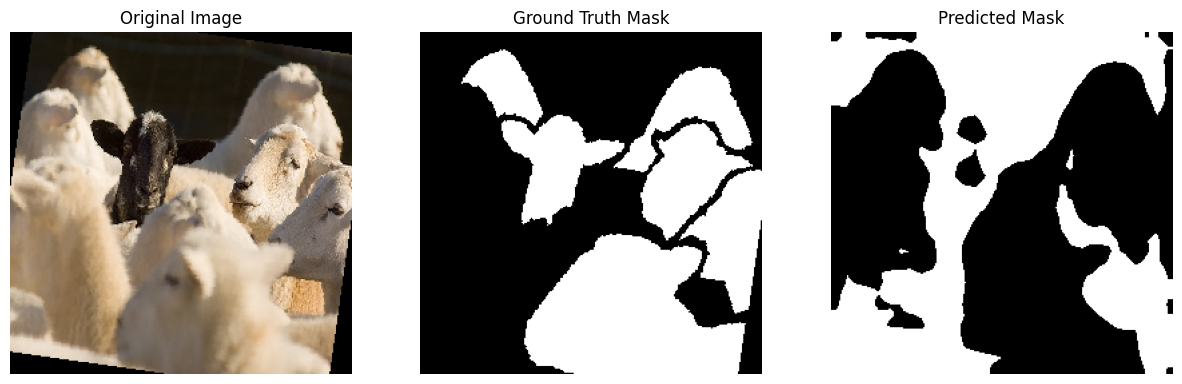

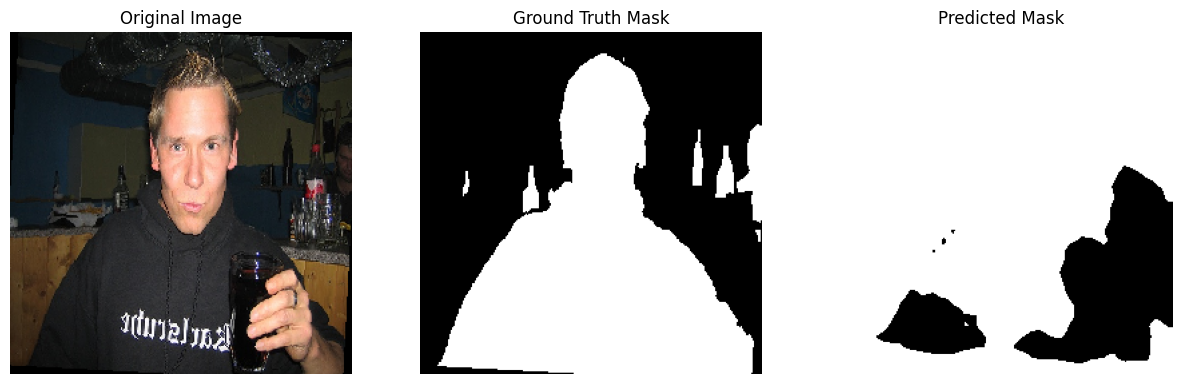

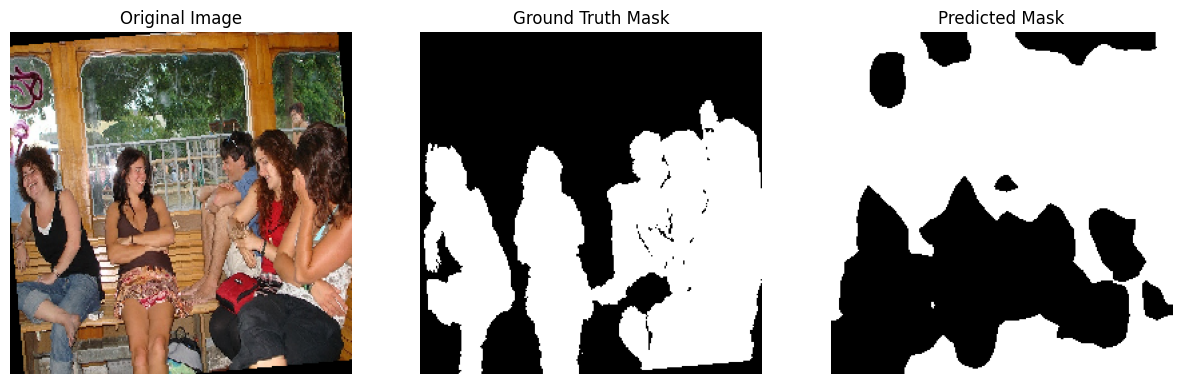

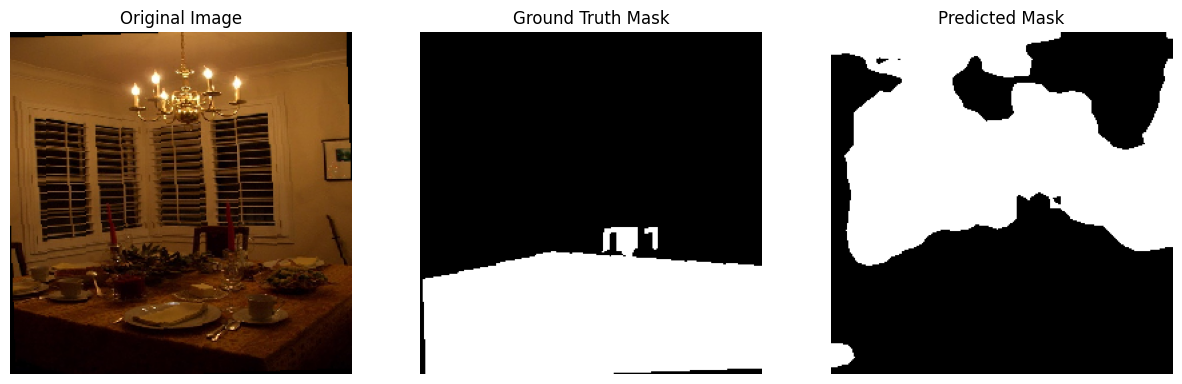

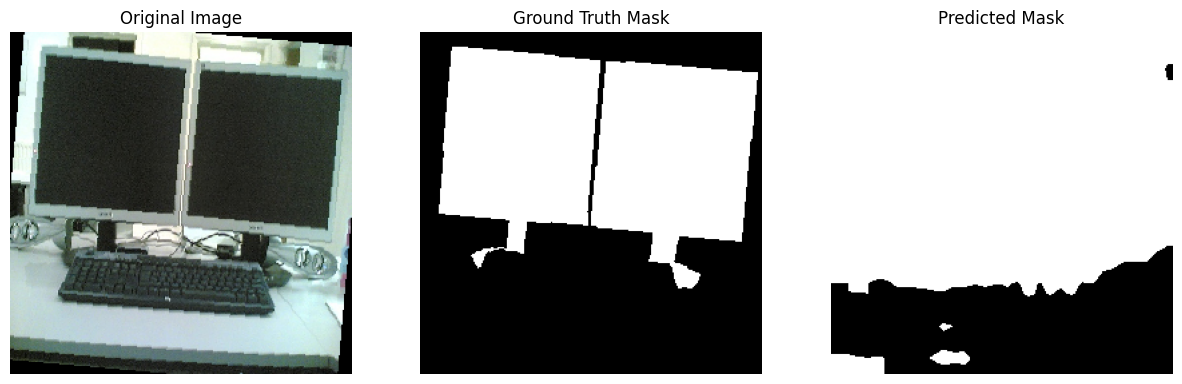

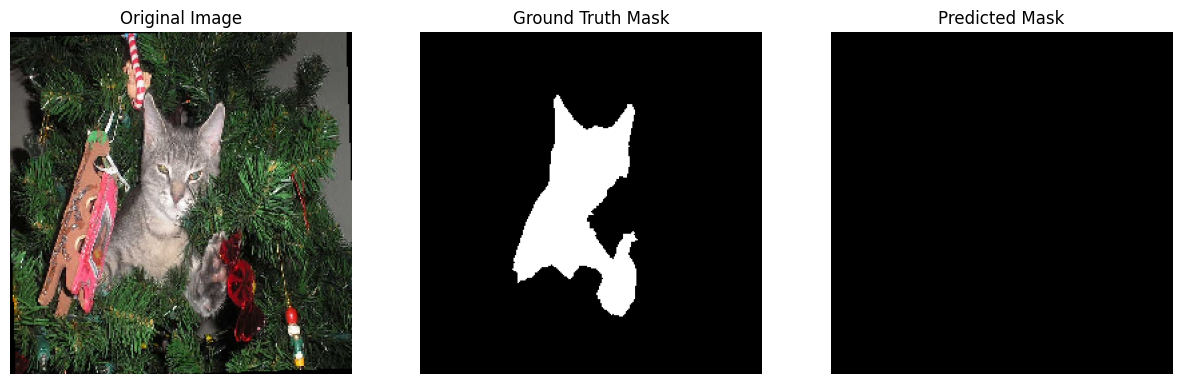

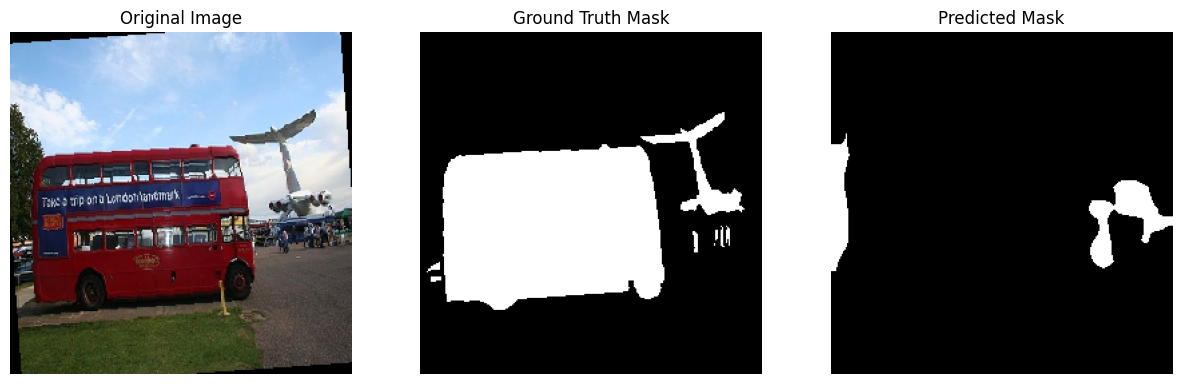

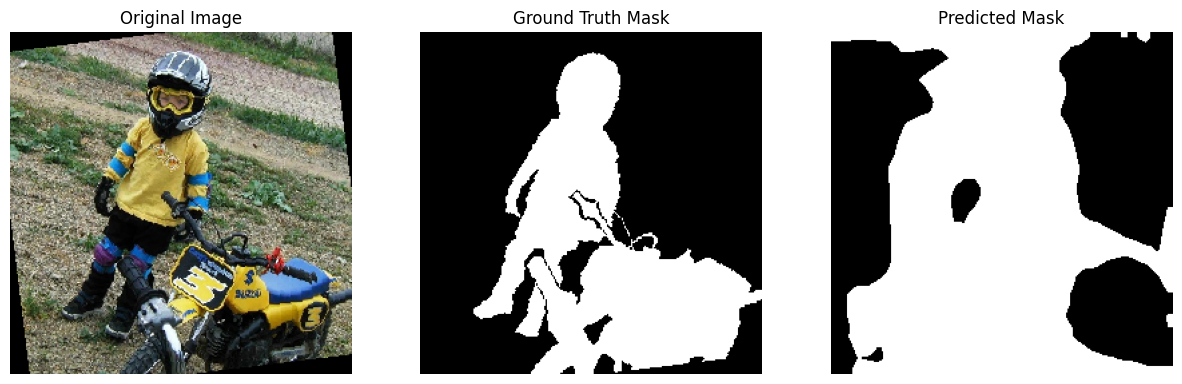

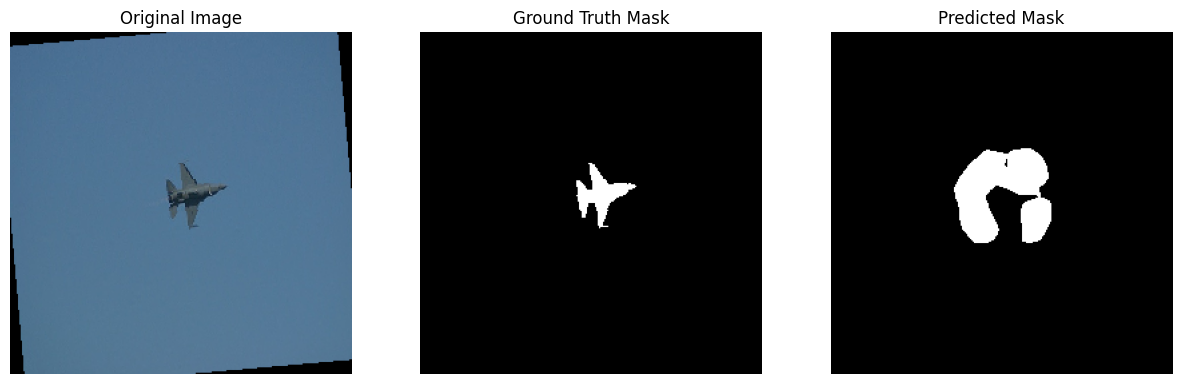

In [56]:
import torchvision
import matplotlib.pyplot as plt

def visualize_predictions(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            outputs = model(images)["out"]

            predicted_masks = torch.sigmoid(outputs)
            predicted_masks = (predicted_masks > 0.5).float()

            for i in range(images.size(0)):
                un_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])
                original_image = un_normalize(images[i]).cpu().numpy().transpose(1, 2, 0)

                original_mask = masks[i].cpu().squeeze().numpy()
                predicted_mask = predicted_masks[i].cpu().squeeze().numpy()

                fig, ax = plt.subplots(1, 3, figsize=(15, 5))
                ax[0].imshow(original_image)
                ax[0].set_title('Original Image')
                ax[0].axis('off')

                ax[1].imshow(original_mask, cmap='gray')
                ax[1].set_title('Ground Truth Mask')
                ax[1].axis('off')

                ax[2].imshow(predicted_mask, cmap='gray')
                ax[2].set_title('Predicted Mask')
                ax[2].axis('off')

                plt.show()


visualize_predictions(trained_model, val_loader, device)